# TensorFlowのモデルをTensorRTに変換する
# Jetson Nanoを使用する場合はメモリの都合上、Jetson Nanoが遅くなります。他のChromiumタブを開くなどは控えてください。

jupyter-labを使用する際のGPUのエラーログを消すには下記の手順が必要です。

1. chromium-browser --disable-gpu
2. jupyter-lab


物体検出のModel Zooが存在しており、そこからモデルを取得します。

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

高速なSSD_liteをTensorRTエンジン化します。

In [0]:
import os
import warnings

warnings.filterwarnings('ignore')

resplace_ssd_model_name = './ssdlite_mobilenet_v2_coco_2018_05_09/'

# ネットワークにつながっている場合のみ

まずモデルをダウンロードします。ネットワーク上から学習済みモデルを取得して保存します。

In [0]:
import requests
import tarfile

ssd_faster_net = 'http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz'
ssd_model_name = os.path.basename(ssd_faster_net)
resplace_ssd_model_name = ssd_model_name.replace('.tar.gz', '')

r = requests.get(ssd_faster_net)

with open('./' + ssd_model_name, 'wb') as f:  
    f.write(r.content)

with tarfile.open(ssd_model_name, 'r:gz') as tf:
    tf.extractall(path='./')


今回の変換対象であるフローズングラフがあるか確認します。

In [0]:
for (dirpath, dirnames, filenames) in os.walk(resplace_ssd_model_name):
    print(filenames)
    break


['pipeline.config', 'checkpoint', 'model.ckpt.data-00000-of-00001', 'model.ckpt.index', 'frozen_inference_graph.pb', 'trt_inference_graph_min_seg_3_60p_work_space.engine', 'model.ckpt.meta', 'trt_inference_graph.engine']


下記のコードでTensorFlowのモデルを読み込みます。TensorFlowで警告が出ますが将来的に消される関数などの警告になります。

In [0]:
import tensorflow.contrib.tensorrt as trt
import tensorflow as tf

with tf.gfile.GFile(resplace_ssd_model_name + '/frozen_inference_graph.pb', "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())


TensorRTに使用予定のGPUワークスペースサイズからTensorFlowに使用可能なGPU比率を導出します。
下記のケースは

- Jetson Nano: 4GB
- TensorRTで使用するメモリサイズ:約105kB
- TensorFlowのGPU比率：99.9%

TensorRTで使用する理想的なメモリサイズは現状では実験的に求めることしかできません。

TensorRTにメモリを与えすぎると変換が上手く動作せず”OutOfMemory Error”が発生します。”OutOfMemory Error”が発生すると正常終了するのですが変換処理は正常に動作しないのでノード数は減少しません。

逆に少なすぎるとTensorRTが十分にメモリを使用できません。

In [0]:
max_workspace_size = 1 << 20
# Jetson Nano memory size: 4051 * 1000 * 1000  
tensorflow_gpu_memory_fraction = ((4051 * 1000 * 1000) - max_workspace_size) / (4051 * 1000 * 1000)
tensorflow_gpu_memory_fraction

0.9997411562577141

あらかじめセッションを設定しておくとメモリの枯渇で止まることがないためセッションを設定しておきます。

In [0]:
tf_sess = tf.Session()

使用するGPUの比率や入力と物体検出の出力、モデルの設定を行います。

In [0]:
%%time
# GPU使用量を割り当て
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = tensorflow_gpu_memory_fraction)

tf_config = tf.ConfigProto(gpu_options=gpu_options)

tf_sess = tf.Session(config=tf_config)

# グラフを設定
tf.import_graph_def(graph_def, name='')

# 入力と出力のTensor名を割り当て
tf_input = tf_sess.graph.get_tensor_by_name('image_tensor:0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

CPU times: user 11.5 s, sys: 180 ms, total: 11.7 s
Wall time: 12 s


下記のコードでTensorRTに変換します。変換にかかる時間も導出します。output_nodesの確認方法は後述します。

In [0]:
%%time
batch_size = 4
output_nodes = ['detection_boxes', 'detection_classes', 'detection_scores', 'num_detections']

trt_graph_def = trt.create_inference_graph(
  graph_def,
  output_nodes,
  max_batch_size=batch_size,
  max_workspace_size_bytes=max_workspace_size,
  precision_mode="FP16",
)


CPU times: user 1min 6s, sys: 8.8 s, total: 1min 15s
Wall time: 1min 55s


TensorFlow前と後でのノード数の変化を確認します。元のモデル6129から減っていることが確認できます。Jetson Nanoでは5503という数字になれば成功です。これより多い場合は変換が失敗しています。

In [0]:
len(graph_def.node)

6129

In [0]:
len(trt_graph_def.node)

5503

TensorRTで最適化したモデルを保存します

In [0]:
with tf.gfile.GFile(resplace_ssd_model_name + '/trt_inference_graph.engine', 'wb') as f:
     f.write(trt_graph_def.SerializeToString())

メモリを効率よく使用するため変換したTensorRTを一旦、解放します

In [0]:
import gc
del trt_graph_def
gc.collect()

393830

物体検出対象の画像を表示します。

In [0]:
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time
%matplotlib inline

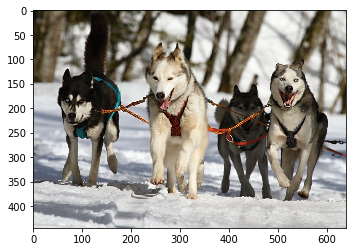

In [0]:
IMAGE_PATH = 'data/huskies.jpg'
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((300, 300)))
image = np.array(image_resized)

バッチサイズ分、画像データをarrayに収容します。

In [0]:
image_array = []

for i in range(batch_size):
    image_array.append(image)
  
image_array = np.array(image_array)
image_array.shape

(4, 300, 300, 3)

物体検出を行います。

In [0]:
%%time
# 推論処理。出力のTensor名を割り当て、入力のTensorに実データを紐付けるためにfeed_dictを使用
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_array[:batch_size, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = num_detections[0]

CPU times: user 29.8 s, sys: 16.5 s, total: 46.3 s
Wall time: 48.1 s


ラベル情報が数値になってしまい認識している物体が何か判断できないので
COCOのデータセットの名前のリストを設定して名前を判断できるようにします。

In [0]:
classes_90 = ["background", "person", "bicycle", "car", "motorcycle",
            "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
            "unknown", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
            "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "unknown", "backpack",
            "umbrella", "unknown", "unknown", "handbag", "tie", "suitcase", "frisbee", "skis",
            "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
            "surfboard", "tennis racket", "bottle", "unknown", "wine glass", "cup", "fork", "knife",
            "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
            "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "unknown", "dining table",
            "unknown", "unknown", "toilet", "unknown", "tv", "laptop", "mouse", "remote", "keyboard",
            "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "unknown",
            "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush" ]

物体検出の結果を確認します。

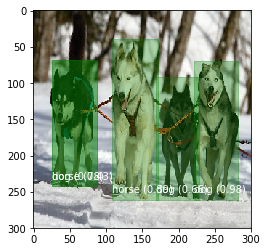

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(int(num_detections)):
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1], y=box[2] - 10, s='%s (%0.2f) ' % (classes_90[int(classes[i])], scores[i]), color='w')

plt.show()

TensorFlowのモデルによる物体検出にかかる1画像当たりの平均推論時間の導出します。Average runtime:が平均推論時間になります。

In [0]:
num_samples = 5

tf.import_graph_def(graph_def, name='')

tf_input = tf_sess.graph.get_tensor_by_name('image_tensor:0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_array[:batch_size, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / (num_samples * batch_size)))


Average runtime: 0.232292 seconds


TensorRTで最適化したモデルを読み込みます。

In [0]:
with tf.gfile.GFile(resplace_ssd_model_name + '/trt_inference_graph.engine', 'rb') as f:
    trt_graph_def = tf.GraphDef()
    trt_graph_def.ParseFromString(f.read())

初期の起動は初期化などで時間がかかるので一旦、物体検出を行います。

In [0]:
%%time
tf.import_graph_def(trt_graph_def, name='')

tf_input = tf_sess.graph.get_tensor_by_name('image_tensor' + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_array[:batch_size, ...]
})

num_samples = 10
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_array[:batch_size, ...]
    })

CPU times: user 19 s, sys: 1.86 s, total: 20.8 s
Wall time: 19.5 s


TensorRTで最適化した後のモデルによる物体検出にかかる1画像当たりの平均推論時間の導出します。

In [0]:
num_samples = 5

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_array[:batch_size, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / (num_samples * batch_size)))

Average runtime: 0.170675 seconds


次の実験のためにセッションをクリアします。

In [0]:
tf_sess.close()
tf.reset_default_graph()

メモリを効率よく使用するため変換したTensorRTを一旦、解放します

In [0]:
import gc
del trt_graph_def
gc.collect()

0

### *minimum_segment_size*サイズを変更してノードの減少数の変化を確認します。

In [0]:
%%time

trt_graph_def = trt.create_inference_graph(
  graph_def,
  output_nodes,
  max_batch_size=batch_size,
  max_workspace_size_bytes=int(max_workspace_size),
  precision_mode="FP16",
  minimum_segment_size=20,
)


CPU times: user 1min 1s, sys: 7.6 s, total: 1min 9s
Wall time: 1min 55s


minimum_segment_sizeはデフォルトは3なのですが20に増やしたので変換後の5503から増えていることを確認します。

In [0]:
len(trt_graph_def.node)

5549

使用するGPUの比率や入力と物体検出の出力、モデルの設定を行います。

In [0]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = tensorflow_gpu_memory_fraction)
tf_config = tf.ConfigProto(gpu_options=gpu_options)

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph_def, name='')

tf_input = tf_sess.graph.get_tensor_by_name('image_tensor' + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_array[:batch_size, ...]
})

TensorRTで最適化した後のモデルによる物体検出にかかる1画像当たりの平均推論時間の導出します。今回のモデルのケースではクラスター間のオーバーヘッドの影響が大きいため速度が速くなっています。クラスター間のオーバーヘッドの影響も残念ながら実験的に確認する方法しか存在していません。

In [0]:
num_samples = 5

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_array[:batch_size, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / (num_samples * batch_size)))

Average runtime: 0.149120 seconds


次の実験のためにセッションをクリアする

In [0]:
tf_sess.close()
tf.reset_default_graph()

import gc
del trt_graph_def
gc.collect()

908272

# is_dynamic_opを使用してキャッシュの効果を確認します。

In [0]:
%%time


trt_graph_def = trt.create_inference_graph(
  graph_def,
  output_nodes,
  max_workspace_size_bytes=int(max_workspace_size),
  precision_mode="FP16",
  is_dynamic_op=True,
  maximum_cached_engines=100,
)

CPU times: user 42.1 s, sys: 420 ms, total: 42.5 s
Wall time: 43.3 s


In [0]:
len(trt_graph_def.node)

5503

使用するGPUの比率や入力と物体検出の出力、モデルの設定を行います。キャッシュの作成のため、初回の推論には時間がかかります。

In [0]:
%%time
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = tensorflow_gpu_memory_fraction)
tf_config = tf.ConfigProto(gpu_options=gpu_options)

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph_def, name='')

tf_input = tf_sess.graph.get_tensor_by_name('image_tensor' + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_array[:batch_size, ...]
})

CPU times: user 43.8 s, sys: 6.79 s, total: 50.6 s
Wall time: 1min 19s


TensorRTで最適化した後のモデルによる物体検出にかかる1画像当たりの平均推論時間の導出します。オーバーヘッドの影響を緩和して高速に推論ができていることが確認できます。

In [0]:
num_samples = 5

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_array[:batch_size, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / (num_samples * batch_size)))

Average runtime: 0.145169 seconds


In [0]:
tf_sess.close()
tf.reset_default_graph()

import gc
del trt_graph_def, graph_def
gc.collect()

258075

# 今までに学んだパラメータを変更してさらなる高速化を行うための方針

基本的な方針は下記になります。
　　　　　
- max_batch_size: 大きい方が良いですがGPUメモリ許容範囲内にする必要があります。
- max_workspace_size_bytes: 大きい方が良いですがGPUメモリ許容範囲内にする必要があります。
- minimum_segment_size: 今回のモデルは大きい方がよいですが大きすぎるとTensorRT対象が減ります。
- is_dynamic_op: バッチサイズを確定しない場合は使用します。
- maximum_cached_engines: データの変更可能性が少ないため、大きくしなくても良いです。

止まった場合はKernel Shutdownもしくは再起動が必要になります。

# Jetson nanoのリソースは少ないのでKerNelをオフにします。

# TensorBoardでTensorRTによるグラフの変換結果を確認します。以下はターミナルで実行します。

Output Nodeが分からないとTensorRTに変換できないので下記コマンドでフローズングラフをグラフに変換してTensorBoardでOutput Nodeを確認できます。このnotebookがあるディレクトリで下記のコマンドをターミナルで実行します。

ディレクトリ移動



- model_dir './ssdlite_mobilenet_v2_coco_2018_05_09/frozen_inference_graph.pb'
 - フローズングラフの指定
- log_dir "./Graph"
 - フローズングラフをTensorBoard用のグラフに変換したときの出力先


python3 import_pb_to_tensorboard.py --model_dir './ssdlite_mobilenet_v2_coco_2018_05_09/frozen_inference_graph.pb' --log_dir "./Graph"

同様にTensorRTで変換されたモデルを確認するため下記のコードをターミナルで実行します。

python3 import_pb_to_tensorboard.py --model_dir "./ssdlite_mobilenet_v2_coco_2018_05_09/trt_inference_graph.engine" --log_dir "./GraphTrt"

TensorBoard確認手順

- ターミナルで`Graph`と`GraphTrt`があるディレクトリに移動

- 下記のコマンドを実行
```
tensorboard --logdir=./Graph
```

別のターミナルを開き

- 下記のコマンドを実行
```
tensorboard --port=6007 --logdir=./GraphTrt
```

ブラウザに'localhost:6006'、'localhost:6007'を入力しTensorFlowのグラフを確認します。